<a href="https://colab.research.google.com/github/TanmayTopkhanewale/Political-Persuasion-Analysis-Uplift-Modeling-/blob/main/G_Political_Persuasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00


Here we will be importing all the models to test and train each of them so that proper analysis is possible and maximum possible variations are tested.

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from causalml.inference.tree import UpliftRandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,
                              recall_score, f1_score, confusion_matrix,
                              classification_report, roc_curve, auc)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [ ]:
df= pd.read_csv(r"/content/Voter-Persuasion.csv")

In [ ]:
df.head()

,VOTER_ID,SET_NO,OPP_SEX,AGE,HH_ND,HH_NR,HH_NI,MED_AGE,NH_WHITE,NH_AA,...,MOVED_AD,MOVED_A,opposite,Partition,CAND1S_L,CAND1S_S,CAND1S_U,CAND2S_L,CAND2S_S,CAND2S_U
0,193801,2,0,28,1,1,1,37,61,34,...,0,0,1,V,0,1,0,0,1,0
1,627701,1,0,53,2,0,0,46,87,8,...,0,0,1,T,0,1,0,0,1,0
2,306924,2,0,68,2,1,0,41,23,64,...,1,1,0,T,0,1,0,1,0,0
3,547609,1,0,66,0,2,0,35,53,29,...,0,0,1,T,0,1,0,0,1,0
4,141105,3,0,23,0,3,1,42,74,18,...,0,0,1,T,0,1,0,0,1,0


In [ ]:
print("MISSING VALUES")

missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("no missing value")

print("TARGET AND TREATMENT DISTRIBUTION")

print("\nTarget (MOVED_A):")
print(df['MOVED_A'].value_counts())
print(f"\nBalance: {df['MOVED_A'].value_counts(normalize=True).to_dict()}")

print("\nTreatment (MESSAGE_A):")
print(df['MESSAGE_A'].value_counts())
print(f"\nBalance: {df['MESSAGE_A'].value_counts(normalize=True).to_dict()}")


MISSING VALUES
no missing value
TARGET AND TREATMENT DISTRIBUTION

Target (MOVED_A):
MOVED_A
0    6266
1    3734
Name: count, dtype: int64

Balance: {0: 0.6266, 1: 0.3734}

Treatment (MESSAGE_A):
MESSAGE_A
1    5000
0    5000
Name: count, dtype: int64

Balance: {1: 0.5, 0: 0.5}


In [ ]:
df_train = df[df['Partition'] == 'T'].copy()
df_test = df[df['Partition'] == 'V'].copy()

In [ ]:
df.columns

Index(['VOTER_ID', 'SET_NO', 'OPP_SEX', 'AGE', 'HH_ND', 'HH_NR', 'HH_NI',
       'MED_AGE', 'NH_WHITE', 'NH_AA', 'NH_ASIAN', 'NH_MULT', 'HISP',
       'COMM_LT10', 'COMM_609P', 'MED_HH_INC', 'COMM_CAR', 'COMM_CP',
       'COMM_PT', 'COMM_WALK', 'KIDS', 'M_MAR', 'F_MAR', 'ED_4COL', 'GENDER_F',
       'GENDER_M', 'H_AFDLN3P', 'H_F1', 'H_M1', 'H_MFDLN3P', 'PARTY_D',
       'PARTY_I', 'PARTY_R', 'VPP_08', 'VPP_12', 'VPR_08', 'VPR_10', 'VPR_12',
       'VG_04', 'VG_06', 'VG_08', 'VG_10', 'VG_12', 'PP_PELIG', 'PR_PELIG',
       'AP_PELIG', 'G_PELIG', 'E_PELIG', 'NL5G', 'NL3PR', 'NL5AP', 'NL2PP',
       'REG_DAYS', 'UPSCALEBUY', 'UPSCALEMAL', 'UPSCALEFEM', 'BOOKBUYERI',
       'FAMILYMAGA', 'FEMALEORIE', 'RELIGIOUSM', 'GARDENINGM', 'CULINARYIN',
       'HEALTHFITN', 'DOITYOURSE', 'FINANCIALM', 'RELIGIOUSC', 'POLITICALC',
       'MEDIANEDUC', 'MESSAGE_A', 'MESSAGE_A_REV', 'I3', 'CAND1_UND',
       'CAND2_UND', 'MOVED_AD', 'MOVED_A', 'opposite', 'Partition', 'CAND1S_L',
       'CAND1S_S', 'CAND

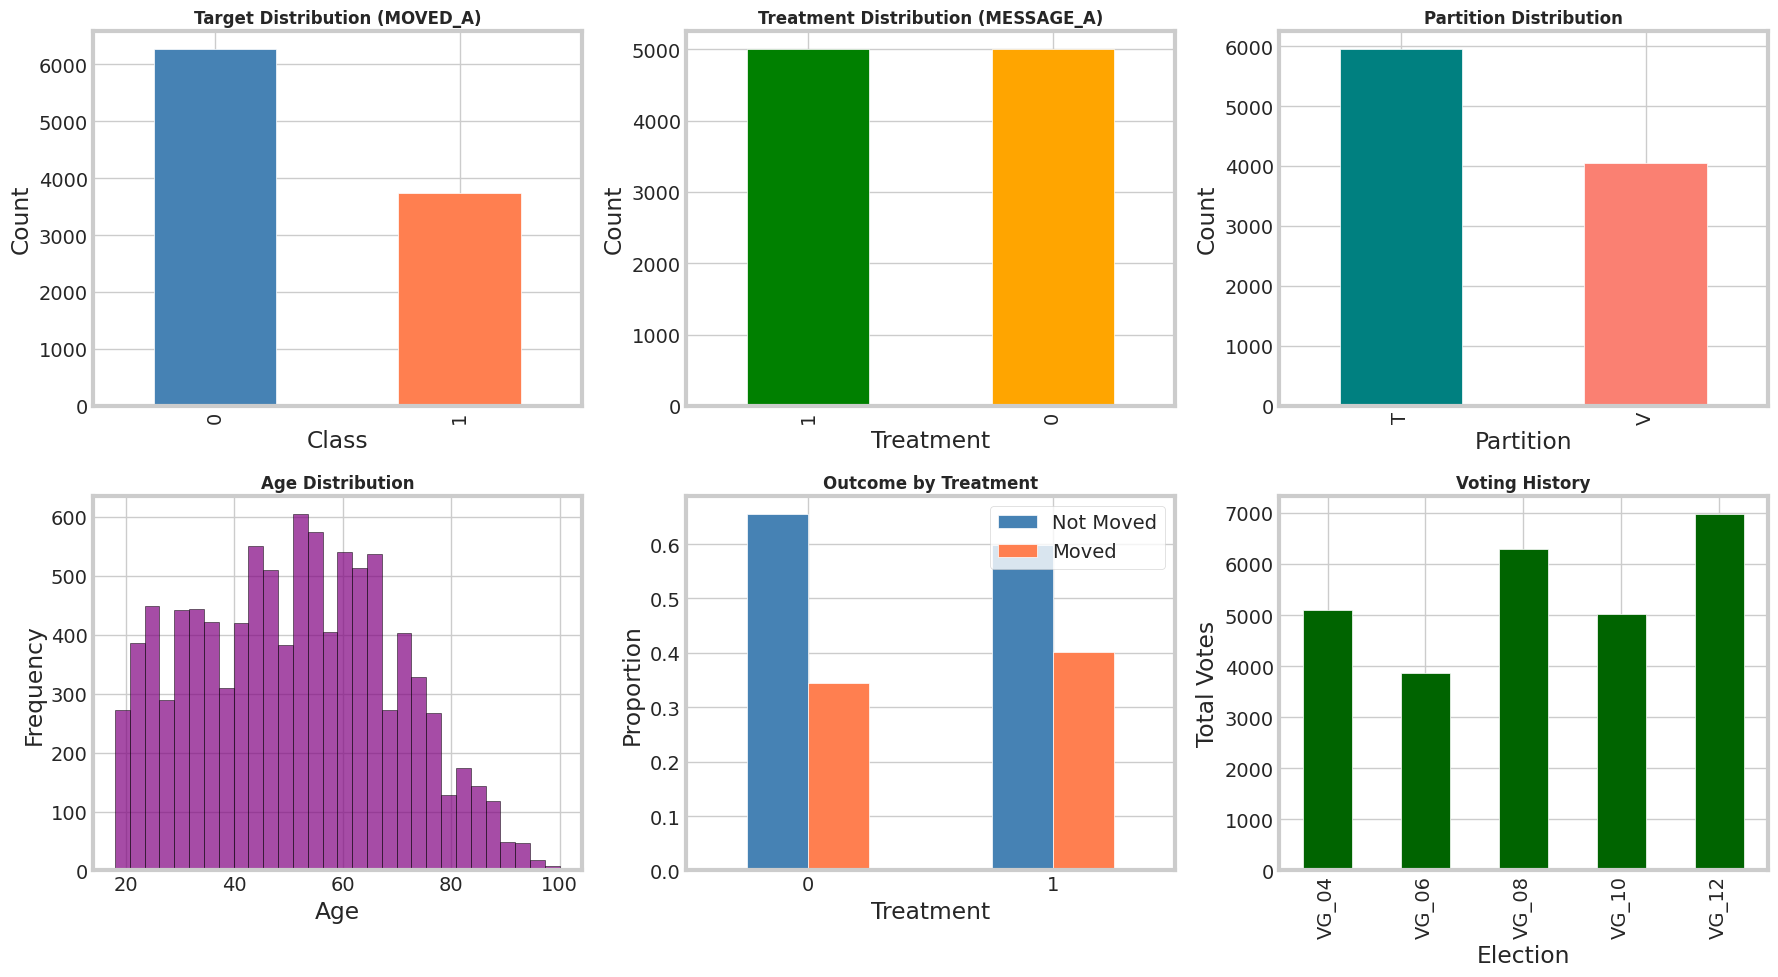

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#target distribution
df['MOVED_A'].value_counts().plot(kind='bar', ax=axes[0,0], color=['steelblue', 'coral'])
axes[0,0].set_title('Target Distribution (MOVED_A)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Class')
axes[0,0].set_ylabel('Count')

# Treatment distribution
df['MESSAGE_A'].value_counts().plot(kind='bar', ax=axes[0,1], color=['green', 'orange'])
axes[0,1].set_title('Treatment Distribution (MESSAGE_A)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Treatment')
axes[0,1].set_ylabel('Count')

# Partition distribution
df['Partition'].value_counts().plot(kind='bar', ax=axes[0,2], color=['teal', 'salmon'])
axes[0,2].set_title('Partition Distribution', fontsize=12, fontweight='bold')
axes[0,2].set_xlabel('Partition')
axes[0,2].set_ylabel('Count')

# Age distribution
df['AGE'].hist(bins=30, ax=axes[1,0], color='purple', alpha=0.7, edgecolor='black')
axes[1,0].set_title('Age Distribution', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Frequency')

# Treatment vs Outcome
ct = pd.crosstab(df['MESSAGE_A'], df['MOVED_A'], normalize='index')
ct.plot(kind='bar', ax=axes[1,1], color=['steelblue', 'coral'])
axes[1,1].set_title('Outcome by Treatment', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Treatment')
axes[1,1].set_ylabel('Proportion')
axes[1,1].legend(['Not Moved', 'Moved'])
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=0)

# Voting history
vote_cols = [c for c in df.columns if c.startswith('VG_')]
if vote_cols:
    df[vote_cols].sum().plot(kind='bar', ax=axes[1,2], color='darkgreen')
    axes[1,2].set_title('Voting History', fontsize=12, fontweight='bold')
    axes[1,2].set_xlabel('Election')
    axes[1,2].set_ylabel('Total Votes')

plt.tight_layout()
plt.show()


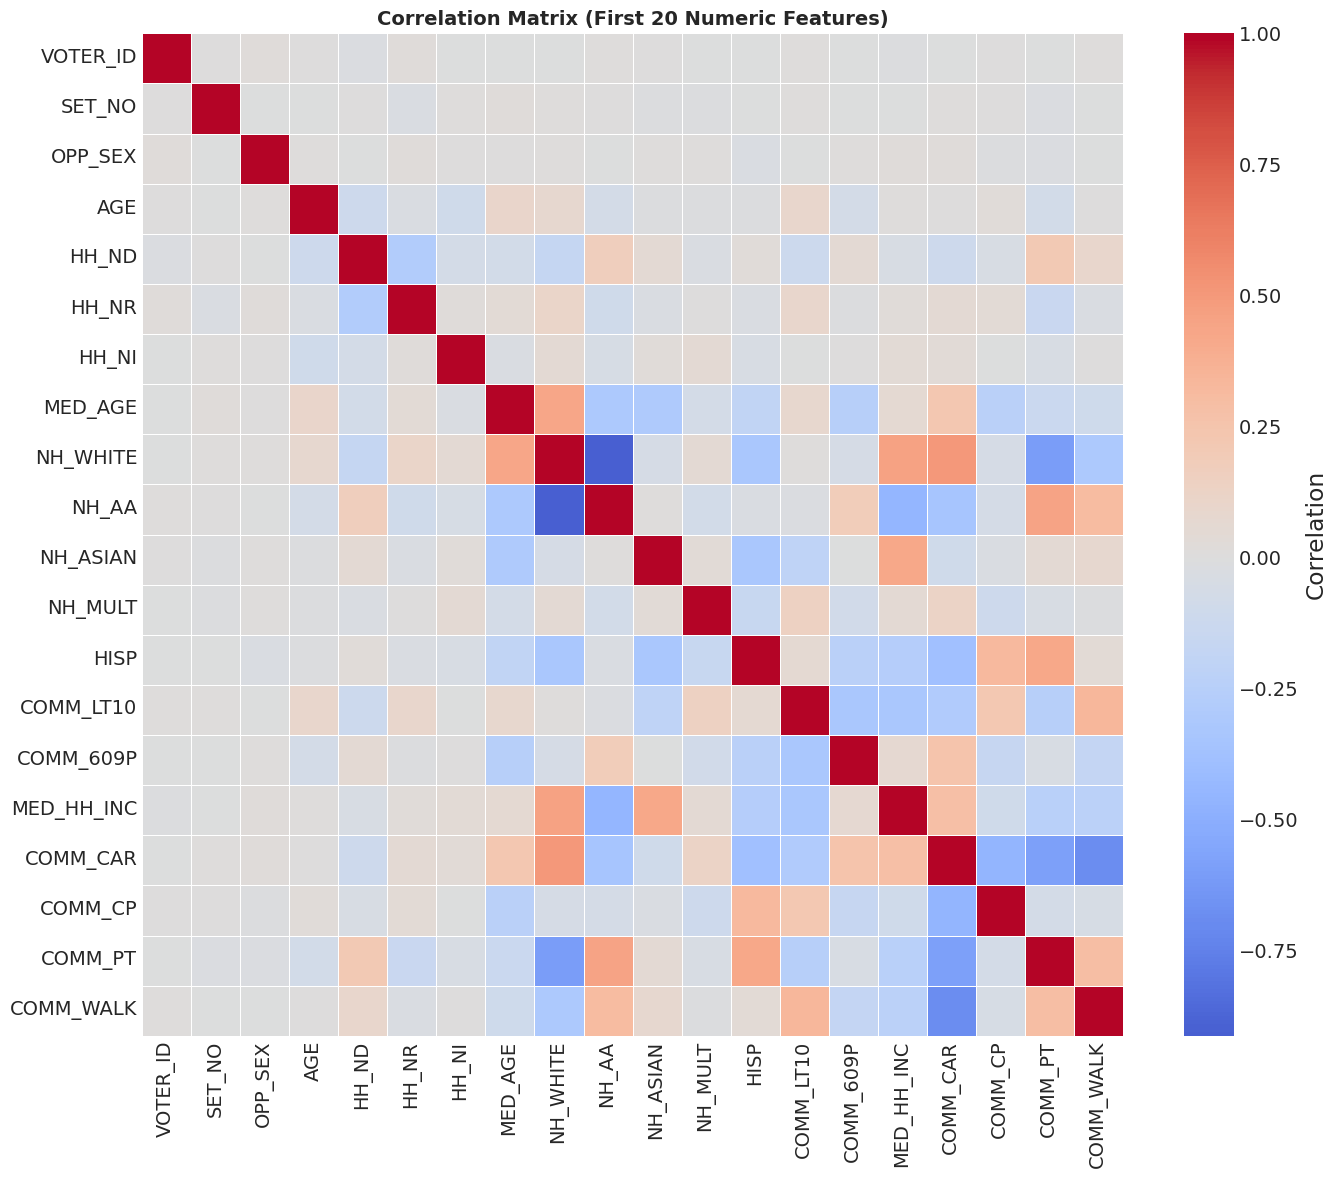

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns[:20]
plt.figure(figsize=(14, 12))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix (First 20 Numeric Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
df.drop("Partition",axis=1).corr()

,VOTER_ID,SET_NO,OPP_SEX,AGE,HH_ND,HH_NR,HH_NI,MED_AGE,NH_WHITE,NH_AA,...,CAND2_UND,MOVED_AD,MOVED_A,opposite,CAND1S_L,CAND1S_S,CAND1S_U,CAND2S_L,CAND2S_S,CAND2S_U
VOTER_ID,1.000000,0.004829,0.013711,0.001071,-0.021323,0.020304,-0.006341,-0.001775,-0.008064,0.012011,...,0.005264,-0.004956,-0.004956,0.004956,-0.005332,0.011042,-0.007703,-0.013727,0.008425,0.005264
SET_NO,0.004829,1.000000,-0.003911,-0.005876,0.001167,-0.024635,0.009744,0.016761,0.008178,-0.000819,...,-0.000957,0.005553,0.005553,-0.005553,0.010829,-0.014160,0.005984,0.005338,-0.003954,-0.000957
OPP_SEX,0.013711,-0.003911,1.000000,0.009523,-0.003552,0.015257,0.002180,0.002029,0.012733,-0.003313,...,-0.002232,-0.006487,-0.006487,0.006487,-0.012945,0.018930,-0.009495,-0.002726,0.003711,-0.002232
AGE,0.001071,-0.005876,0.009523,1.000000,-0.111906,-0.030063,-0.092572,0.098188,0.073202,-0.073316,...,0.000736,-0.026237,-0.026237,0.026237,-0.065189,-0.001714,0.065583,0.009598,-0.008637,0.000736
HH_ND,-0.021323,0.001167,-0.003552,-0.111906,1.000000,-0.280483,-0.074276,-0.083083,-0.169724,0.165693,...,0.017051,0.259323,0.259323,-0.259323,0.175585,-0.363547,0.253566,0.028439,-0.034837,0.017051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAND1S_S,0.011042,-0.014160,0.018930,-0.001714,-0.363547,0.416467,0.027049,0.040545,0.084840,-0.079427,...,-0.183530,-0.657461,-0.657461,0.657461,-0.577662,1.000000,-0.605128,-0.240463,0.319031,-0.183530
CAND1S_U,-0.007703,0.005984,-0.009495,0.065583,0.253566,-0.266303,-0.068881,-0.010601,-0.033514,0.040619,...,0.151226,0.366541,0.366541,-0.366541,-0.300300,-0.605128,1.000000,0.218262,-0.280026,0.151226
CAND2S_L,-0.013727,0.005338,-0.002726,0.009598,0.028439,-0.115532,0.064180,0.020631,0.025204,-0.024202,...,-0.106449,0.214519,0.214519,-0.214519,0.064315,-0.240463,0.218262,1.000000,-0.785978,-0.106449
CAND2S_S,0.008425,-0.003954,0.003711,-0.008637,-0.034837,0.153429,-0.094451,-0.024337,-0.023693,0.022561,...,-0.531076,-0.187660,-0.187660,0.187660,-0.095121,0.319031,-0.280026,-0.785978,1.000000,-0.531076


In [ ]:
TARGET = 'MOVED_A'
EXCLUDE_COLS = [
    'VOTER_ID', 'MESSAGE_A', 'MESSAGE_A_REV', 'Partition',
    'MOVED_AD', 'MOVED_A', 'opposite'
]

print(f"Target: {TARGET}")
print(f"Excluded columns: {EXCLUDE_COLS}")


Target: MOVED_A
Excluded columns: ['VOTER_ID', 'MESSAGE_A', 'MESSAGE_A_REV', 'Partition', 'MOVED_AD', 'MOVED_A', 'opposite']


In [ ]:
df_train = df[df['Partition'] == 'T'].copy()
df_valid = df[df['Partition'] == 'V'].copy()
print(f"\nTraining set: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(df_valid)} ({len(df_valid)/len(df)*100:.1f}%)")



Training set: 5948 (59.5%)
Validation set: 4052 (40.5%)


In [ ]:
feature_cols = [c for c in df.columns if c not in EXCLUDE_COLS]
X_train = df_train[feature_cols].copy()
y_train = df_train[TARGET].copy()
X_valid = df_valid[feature_cols].copy()
y_valid = df_valid[TARGET].copy()

In [ ]:
print(f"\nTotal features: {len(feature_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")


Total features: 72
X_train shape: (5948, 72)
X_valid shape: (4052, 72)


In [ ]:
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

for col in cat_cols:
    cats = X_train[col].astype('category').cat.categories
    X_train[col] = X_train[col].astype('category').cat.codes
    X_valid[col] = pd.Categorical(X_valid[col], categories=cats).codes


Categorical columns (5): ['CAND1S', 'CAND2S', 'I3', 'CAND1_UND', 'CAND2_UND']


In [ ]:
corrs = []
for col in X_train.columns:
    if np.issubdtype(X_train[col].dtype, np.number):
        corr_val = abs(np.corrcoef(X_train[col], y_train)[0, 1])
        corrs.append(corr_val)
    else:
        corrs.append(0)

cor_series = pd.Series(corrs, index=X_train.columns).sort_values(ascending=False)

print("\nTop 15 features by correlation with target:")
print(cor_series.head(15))



Top 15 features by correlation with target:
PARTY_R      0.407295
CAND1_UND    0.363511
PARTY_D      0.344344
HH_NR        0.270648
HH_ND        0.269691
VPP_12       0.178714
GENDER_M     0.157370
GENDER_F     0.157370
CAND2S       0.154675
COMM_PT      0.151091
VPR_08       0.109628
H_F1         0.102696
VPP_08       0.101420
COMM_CAR     0.099750
VPR_10       0.094684
dtype: float64


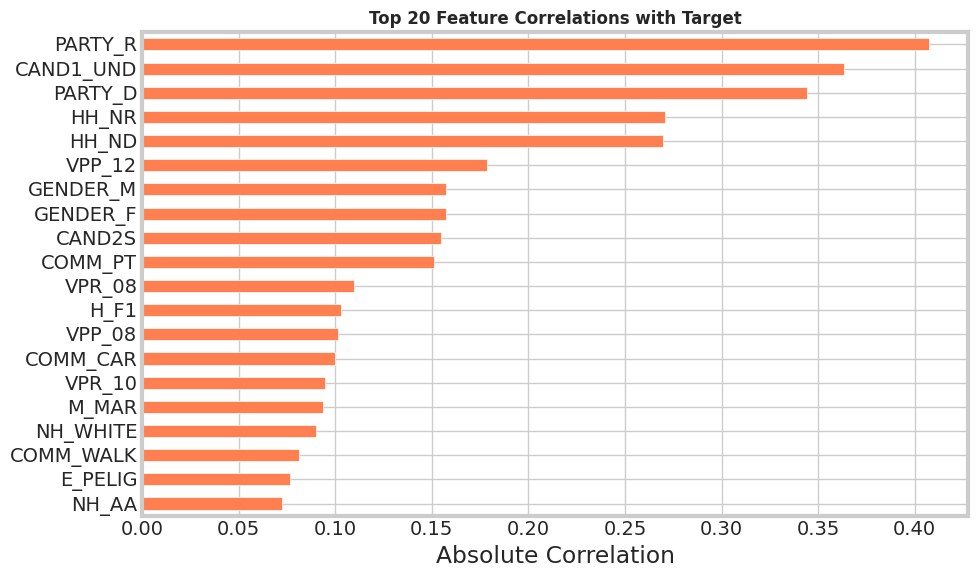

In [ ]:
plt.figure(figsize=(10, 6))
cor_series.head(20).plot(kind='barh', color='coral')
plt.title('Top 20 Feature Correlations with Target', fontsize=12, fontweight='bold')
plt.xlabel('Absolute Correlation')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
threshold = 0.95
leaky_cols = cor_series[cor_series > threshold].index.tolist()

print(f"\nDropping {len(leaky_cols)} leaky columns (correlation > {threshold}):")
print(leaky_cols)

if leaky_cols:
    X_train = X_train.drop(columns=leaky_cols)
    X_valid = X_valid.drop(columns=leaky_cols)
    print(f"✓ Features after removal: {X_train.shape[1]}")
else:
    print("✓ No leaky features detected!")


Dropping 0 leaky columns (correlation > 0.95):
[]
✓ No leaky features detected!


In [ ]:
df_train['MESSAGE_A_STR'] = df_train['MESSAGE_A'].astype(str)
df_valid['MESSAGE_A_STR'] = df_valid['MESSAGE_A'].astype(str)

print("Training UpliftRandomForestClassifier...")
uplift_model = UpliftRandomForestClassifier(
    control_name='0',
    n_estimators=100,
    random_state=42
)

uplift_model.fit(
    X=X_train.values,
    treatment=df_train['MESSAGE_A_STR'].values,
    y=y_train.values
)
scores = []
for t in ['0', '1']:  # or whatever your unique treatment labels are
    scores.append(uplift_model.predict(X_valid.values, [t]*len(X_valid)))
uplift_scores = np.column_stack(scores)

Training UpliftRandomForestClassifier...


In [ ]:
print("---- X_train describe ----")
print(X_train.describe())
print("\n---- X_valid describe ----")
print(X_valid.describe())

print("\nUnique values in y_train:")
print(pd.Series(y_train).value_counts())

print("\nShapes:")
print("X_train:", X_train.shape, "X_valid:", X_valid.shape)

print("\nMatching columns (True=good)?", (X_train.columns == X_valid.columns).all())

print("\nModel fit status (check type):", type(uplift_model))

print("\n--- Check predictions on first 3 samples ---")
print("Control prediction:", uplift_model.predict(X_valid.values[:3], ['0']*3))
print("Treatment prediction:", uplift_model.predict(X_valid.values[:3], ['1']*3))

print("\n--- Head of uplift_scores DataFrame ---")
print(uplift_scores)


---- X_train describe ----
            SET_NO      OPP_SEX          AGE        HH_ND        HH_NR  \
count  5948.000000  5948.000000  5948.000000  5948.000000  5948.000000   
mean      2.003362     0.577841    50.837256     1.207465     0.731506   
std       0.816009     5.270216    18.093160     1.312971     1.056677   
min       1.000000     0.000000    18.000000     0.000000     0.000000   
25%       1.000000     0.000000    36.000000     0.000000     0.000000   
50%       2.000000     0.000000    51.000000     1.000000     0.000000   
75%       3.000000     0.000000    64.000000     2.000000     1.000000   
max       3.000000    84.000000   100.000000     9.000000     9.000000   

             HH_NI      MED_AGE     NH_WHITE        NH_AA     NH_ASIAN  ...  \
count  5948.000000  5948.000000  5948.000000  5948.000000  5948.000000  ...   
mean      0.618359    39.149966    66.632818    21.406523     3.605582  ...   
std       0.927476     6.890752    19.581256    17.771720     3.72067


Top 20 Important Features:
M_MAR         0.070457
COMM_609P     0.056699
PARTY_R       0.049919
F_MAR         0.046088
COMM_LT10     0.041760
MED_AGE       0.040895
ED_4COL       0.036873
REG_DAYS      0.036374
E_PELIG       0.031876
HH_NR         0.030371
MED_HH_INC    0.029212
AGE           0.029062
NH_AA         0.027752
KIDS          0.024438
CAND1S        0.024049
HISP          0.022956
NH_MULT       0.022126
G_PELIG       0.021522
NH_WHITE      0.019675
CAND1_UND     0.019478
dtype: float64


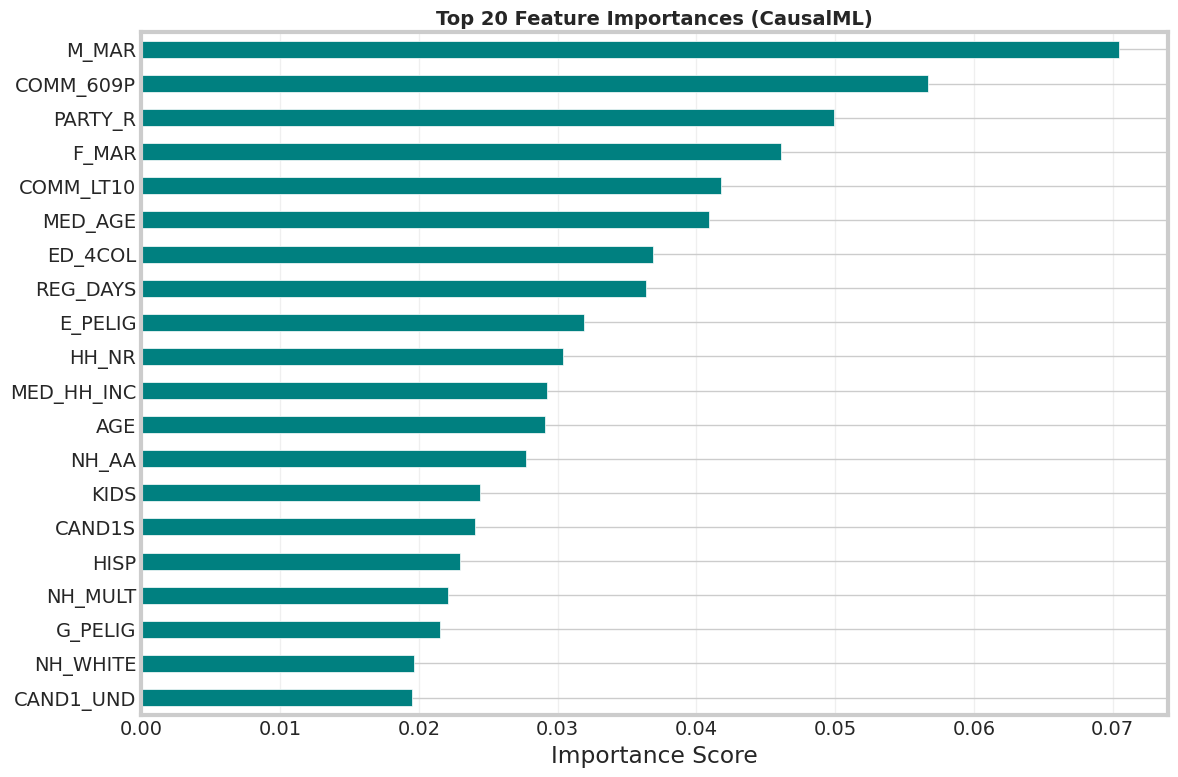

In [ ]:
importances = pd.Series(uplift_model.feature_importances_, index=X_train.columns)
important_cols = importances.sort_values(ascending=False).head(20).index.tolist()

print("\nTop 20 Important Features:")
print(importances.sort_values(ascending=False).head(20))

# Visualize
plt.figure(figsize=(12, 8))
importances.sort_values(ascending=False).head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Feature Importances (CausalML)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(uplift_model.predict(X_valid.values[:2], ['1']*2))
print(uplift_model.predict(X_valid.values[:2], ['0']*2))

          0         1  recommended_treatment   delta_1  max_delta
0  0.411404  0.419352                      1  0.007948   0.007948
1  0.390438  0.411261                      1  0.020823   0.020823
          0         1  recommended_treatment   delta_1  max_delta
0  0.411404  0.419352                      1  0.007948   0.007948
1  0.390438  0.411261                      1  0.020823   0.020823


In [ ]:
print(np.unique(df_train['MESSAGE_A']))        # or your treatment column name
print(np.unique(df_valid['MESSAGE_A']))

[0 1]
[0 1]


In [ ]:
print(X_valid.describe())

            SET_NO      OPP_SEX          AGE        HH_ND        HH_NR  \
count  4052.000000  4052.000000  4052.000000  4052.000000  4052.000000   
mean      2.009625     0.601431    50.917325     1.218164     0.724580   
std       0.820712     5.579729    18.238967     1.305774     1.070305   
min       1.000000     0.000000    18.000000     0.000000     0.000000   
25%       1.000000     0.000000    36.000000     0.000000     0.000000   
50%       2.000000     0.000000    51.000000     1.000000     0.000000   
75%       3.000000     0.000000    64.000000     2.000000     1.000000   
max       3.000000    86.000000   100.000000     9.000000     9.000000   

             HH_NI      MED_AGE     NH_WHITE        NH_AA     NH_ASIAN  ...  \
count  4052.000000  4052.000000  4052.000000  4052.000000  4052.000000  ...   
mean      0.602665    39.178924    65.981737    22.079220     3.529121  ...   
std       0.927153     6.908352    19.821859    18.136619     3.547316  ...   
min       0.00000

In [ ]:
#individual treatment
# For binary treatments, the effect of '1' vs '0' is:
uplift_individual = uplift_scores[:, 1] - uplift_scores[:, 0]


In [ ]:
count_positive = (uplift_individual > 0).sum()
percent_positive = (uplift_individual > 0).mean() * 100

count_negative = (uplift_individual < 0).sum()
percent_negative = (uplift_individual < 0).mean() * 100

print(f"Positive uplift: {count_positive} ({percent_positive:.1f}%)")
print(f"Negative uplift: {count_negative} ({percent_negative:.1f}%)")


Positive uplift: 3993 (98.5%)
Negative uplift: 59 (1.5%)


In [ ]:
df_valid = df_valid.reset_index(drop=True)
df_valid['uplift_score'] = uplift_individual

In [ ]:
uplift_scores

array([[0.41140382, 0.41935176, 1.        , ..., 1.        , 0.00794795,
        0.00794795],
       [0.39043812, 0.41126071, 1.        , ..., 1.        , 0.02082258,
        0.02082258],
       [0.38858528, 0.40931192, 1.        , ..., 1.        , 0.02072665,
        0.02072665],
       ...,
       [0.39667   , 0.4135679 , 1.        , ..., 1.        , 0.0168979 ,
        0.0168979 ],
       [0.39218482, 0.42562426, 1.        , ..., 1.        , 0.03343943,
        0.03343943],
       [0.39623289, 0.41593635, 1.        , ..., 1.        , 0.01970346,
        0.01970346]])

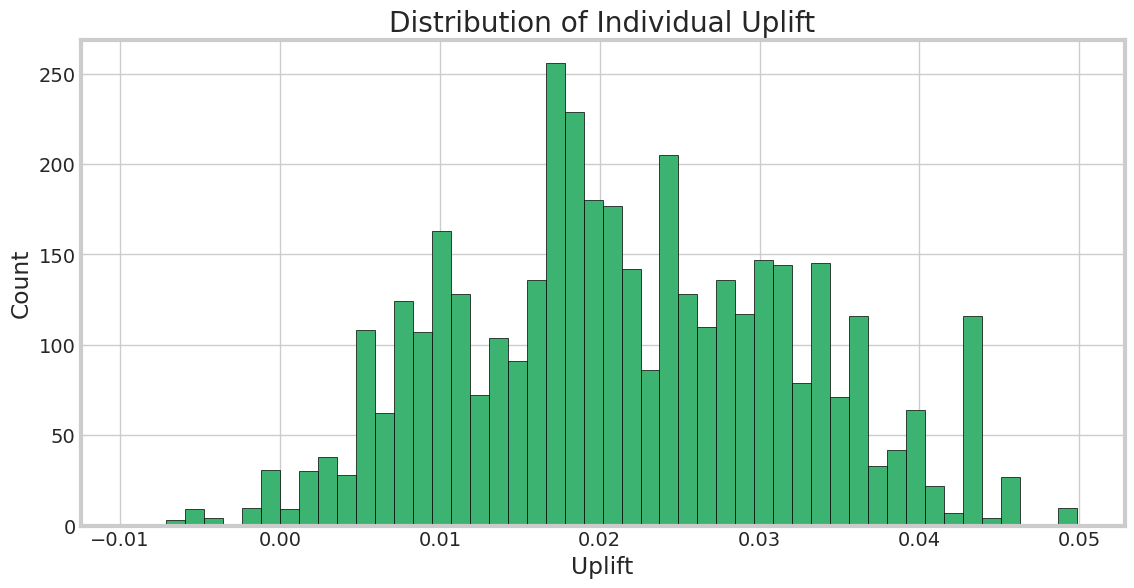

In [ ]:
plt.hist(uplift_individual, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('Distribution of Individual Uplift')
plt.xlabel('Uplift')
plt.ylabel('Count')
plt.show()


In [ ]:
X_train_imp = X_train[important_cols].copy()
X_valid_imp = X_valid[important_cols].copy()

print(f"\nTraining on {len(important_cols)} important features")
print(f"X_train_imp shape: {X_train_imp.shape}")

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=5000, random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
}

try:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    models['LightGBM'] = LGBMClassifier(random_state=42, verbose=-1)
except:
    pass

try:
    models['CatBoost'] = CatBoostClassifier(verbose=0, random_state=42)
except:
    pass

print(f"\nTotal models: {len(models)}")



Training on 20 important features
X_train_imp shape: (5948, 20)

Total models: 11


In [ ]:
results_imp = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train_imp, y_train)
        y_pred = model.predict(X_valid_imp)
        y_pred_proba = model.predict_proba(X_valid_imp)[:, 1] if hasattr(model, 'predict_proba') else y_pred

        acc = accuracy_score(y_valid, y_pred)
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        precision = precision_score(y_valid, y_pred, zero_division=0)
        recall = recall_score(y_valid, y_pred, zero_division=0)
        f1 = f1_score(y_valid, y_pred, zero_division=0)

        results_imp.append((name, acc, auc_score, precision, recall, f1))
        print(f"  Accuracy: {acc:.4f} | AUC: {auc_score:.4f} | F1: {f1:.4f}")
    except Exception as e:
        print(f"  Error: {str(e)}")

results_df_imp = pd.DataFrame(results_imp, columns=['Model', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1'])
results_df_imp = results_df_imp.sort_values('AUC', ascending=False)

print("\n" + "="*60)
print("MODEL RESULTS (IMPORTANT FEATURES)")
print("="*60)
print(results_df_imp.to_string(index=False))


Training RandomForest...
  Accuracy: 0.8201 | AUC: 0.8836 | F1: 0.7640

Training GradientBoosting...
  Accuracy: 0.8384 | AUC: 0.9051 | F1: 0.7958

Training ExtraTrees...
  Accuracy: 0.7986 | AUC: 0.8676 | F1: 0.7335

Training AdaBoost...
  Accuracy: 0.8300 | AUC: 0.8944 | F1: 0.7920

Training DecisionTree...
  Accuracy: 0.7564 | AUC: 0.7432 | F1: 0.6746

Training LogisticRegression...
  Accuracy: 0.7488 | AUC: 0.8121 | F1: 0.6241

Training KNeighbors...
  Accuracy: 0.6150 | AUC: 0.5843 | F1: 0.4222

Training GaussianNB...
  Accuracy: 0.6863 | AUC: 0.7573 | F1: 0.4970

Training XGBoost...
  Accuracy: 0.8169 | AUC: 0.8884 | F1: 0.7580

Training LightGBM...
  Accuracy: 0.8287 | AUC: 0.8994 | F1: 0.7778

Training CatBoost...
  Accuracy: 0.8346 | AUC: 0.9028 | F1: 0.7864

MODEL RESULTS (IMPORTANT FEATURES)
             Model  Accuracy      AUC  Precision   Recall       F1
  GradientBoosting  0.838351 0.905065   0.739282 0.861580 0.795759
          CatBoost  0.834650 0.902796   0.745015 0.

In [ ]:
results_full = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:, 1] if hasattr(model, 'predict_proba') else y_pred

        acc = accuracy_score(y_valid, y_pred)
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        precision = precision_score(y_valid, y_pred, zero_division=0)
        recall = recall_score(y_valid, y_pred, zero_division=0)
        f1 = f1_score(y_valid, y_pred, zero_division=0)

        results_full.append((name, acc, auc_score, precision, recall, f1))
        print(f"  Accuracy: {acc:.4f} | AUC: {auc_score:.4f} | F1: {f1:.4f}")
    except Exception as e:
        print(f"  Error: {str(e)}")

results_df_full = pd.DataFrame(results_full, columns=['Model', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1'])
results_df_full = results_df_full.sort_values('AUC', ascending=False)

print("\n" + "="*60)
print("MODEL RESULTS (FULL FEATURES)")
print("="*60)
print(results_df_full.to_string(index=False))



Training RandomForest...
  Accuracy: 0.9482 | AUC: 0.9842 | F1: 0.9314

Training GradientBoosting...
  Accuracy: 0.9445 | AUC: 0.9834 | F1: 0.9267

Training ExtraTrees...
  Accuracy: 0.9408 | AUC: 0.9826 | F1: 0.9205

Training AdaBoost...
  Accuracy: 0.8546 | AUC: 0.9090 | F1: 0.8092

Training DecisionTree...
  Accuracy: 0.9373 | AUC: 0.9330 | F1: 0.9145

Training LogisticRegression...
  Accuracy: 0.7589 | AUC: 0.8331 | F1: 0.6676

Training KNeighbors...
  Accuracy: 0.6135 | AUC: 0.5834 | F1: 0.4157

Training GaussianNB...
  Accuracy: 0.6977 | AUC: 0.7582 | F1: 0.5129

Training XGBoost...
  Accuracy: 0.9573 | AUC: 0.9922 | F1: 0.9428

Training LightGBM...
  Accuracy: 0.9571 | AUC: 0.9922 | F1: 0.9428

Training CatBoost...
  Accuracy: 0.9566 | AUC: 0.9930 | F1: 0.9421

MODEL RESULTS (FULL FEATURES)
             Model  Accuracy      AUC  Precision   Recall       F1
          CatBoost  0.956565 0.992970   0.918001 0.967589 0.942143
          LightGBM  0.957058 0.992225   0.918642 0.96826


FEATURE SET COMPARISON
             Model  AUC_Full  AUC_Important  Difference
  GradientBoosting  0.983434       0.905065   -0.078369
          CatBoost  0.992970       0.902796   -0.090175
          LightGBM  0.992225       0.899371   -0.092854
          AdaBoost  0.908975       0.894370   -0.014605
           XGBoost  0.992197       0.888434   -0.103763
      RandomForest  0.984244       0.883611   -0.100633
        ExtraTrees  0.982643       0.867552   -0.115091
LogisticRegression  0.833050       0.812146   -0.020904
        GaussianNB  0.758170       0.757293   -0.000877
      DecisionTree  0.932998       0.743241   -0.189757
        KNeighbors  0.583419       0.584255    0.000836


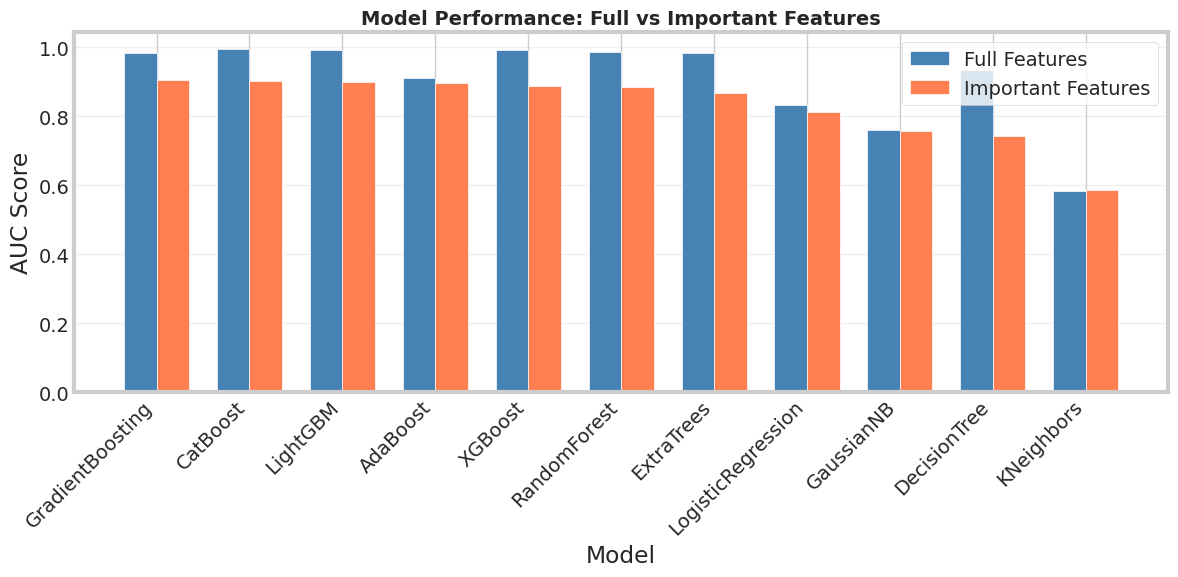

In [ ]:
comparison = pd.merge(
    results_df_full[['Model', 'AUC']].rename(columns={'AUC': 'AUC_Full'}),
    results_df_imp[['Model', 'AUC']].rename(columns={'AUC': 'AUC_Important'}),
    on='Model', how='outer'
)
comparison['Difference'] = comparison['AUC_Important'] - comparison['AUC_Full']
comparison = comparison.sort_values('AUC_Important', ascending=False)

print("\n" + "="*60)
print("FEATURE SET COMPARISON")
print("="*60)
print(comparison.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['AUC_Full'], width, label='Full Features', color='steelblue')
ax.bar(x + width/2, comparison['AUC_Important'], width, label='Important Features', color='coral')

ax.set_xlabel('Model')
ax.set_ylabel('AUC Score')
ax.set_title('Model Performance: Full vs Important Features', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Analyzing: GradientBoosting


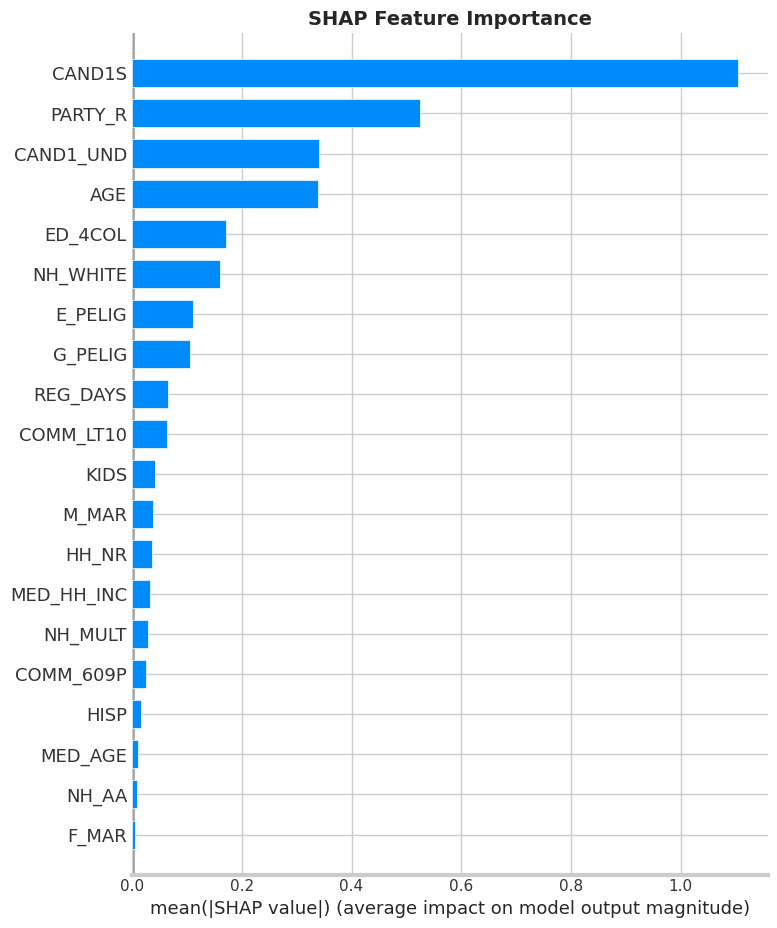

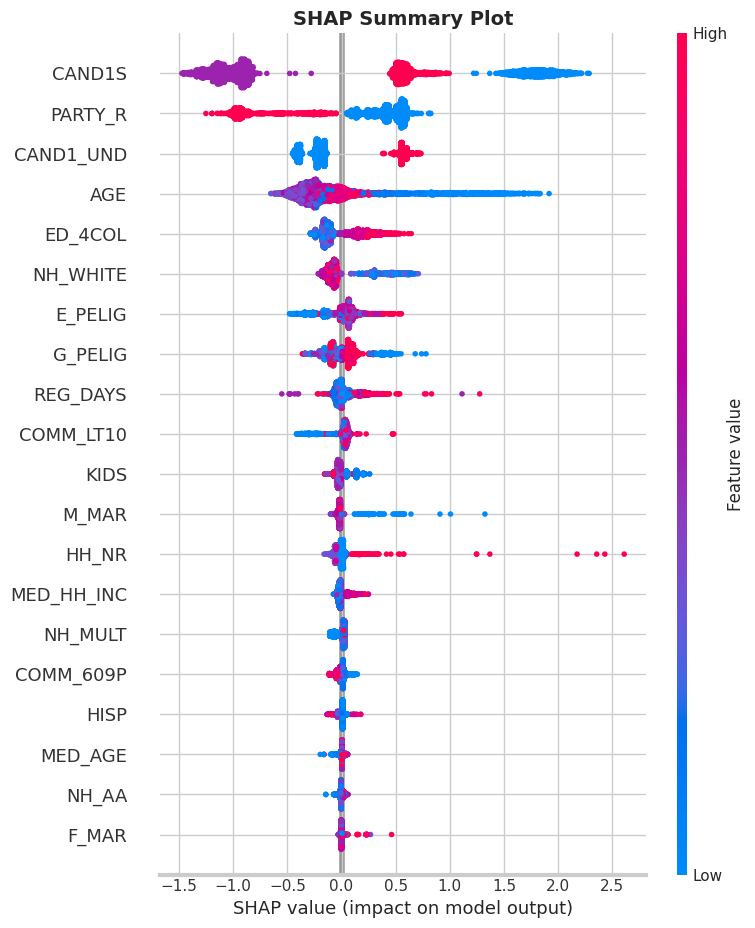

In [ ]:
best_model_name = results_df_imp.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Analyzing: {best_model_name}")
best_model.fit(X_train_imp, y_train)
try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_valid_imp)

    # Summary plot (bar)
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_valid_imp, plot_type="bar", show=False)
    else:
        shap.summary_plot(shap_values, X_valid_imp, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Detailed beeswarm
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_valid_imp, show=False)
    else:
        shap.summary_plot(shap_values, X_valid_imp, show=False)
    plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"SHAP error: {str(e)}")


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name in list(models.keys())[:5]:
    model = models[name]
    print(f"\nEvaluating {name} with 5-fold CV...")
    try:
        cv_scores = cross_val_score(model, X_train_imp, y_train, cv=kf, scoring='roc_auc')
        print(f"  CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except Exception as e:
        print(f"  Error: {str(e)}")


Evaluating RandomForest with 5-fold CV...
  CV AUC: 0.8803 (+/- 0.0105)

Evaluating GradientBoosting with 5-fold CV...
  CV AUC: 0.9007 (+/- 0.0066)

Evaluating ExtraTrees with 5-fold CV...
  CV AUC: 0.8679 (+/- 0.0120)

Evaluating AdaBoost with 5-fold CV...
  CV AUC: 0.8853 (+/- 0.0097)

Evaluating DecisionTree with 5-fold CV...
  CV AUC: 0.7382 (+/- 0.0140)


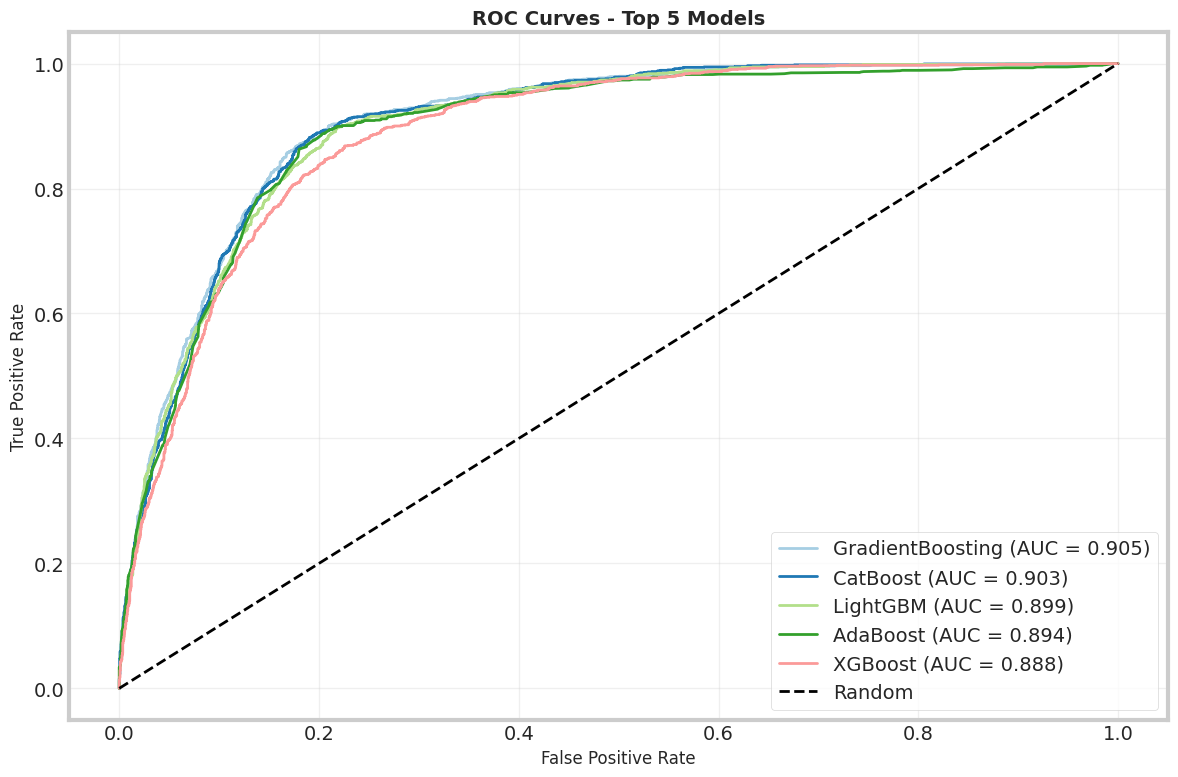

In [ ]:
plt.figure(figsize=(12, 8))

for name in results_df_imp['Model'].head(5):
    model = models[name]
    model.fit(X_train_imp, y_train)

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_valid_imp)[:, 1]
        fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Top 5 Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

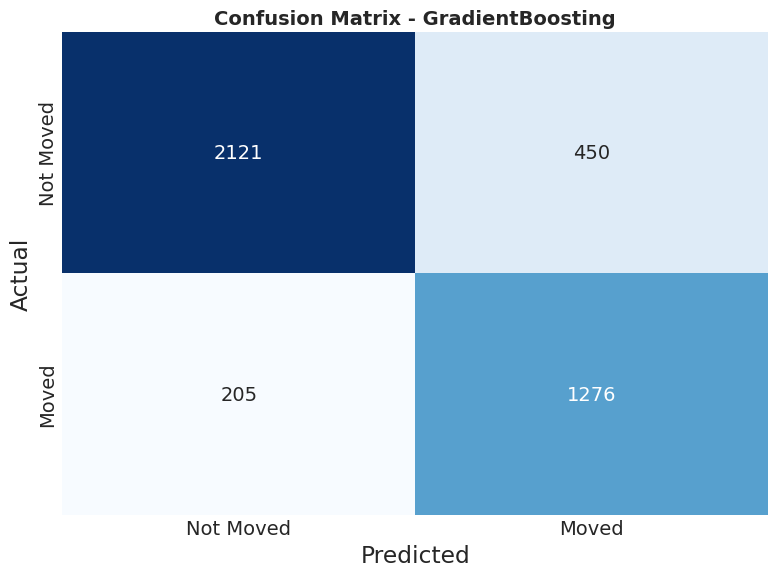


Classification Report:
              precision    recall  f1-score   support

   Not Moved       0.91      0.82      0.87      2571
       Moved       0.74      0.86      0.80      1481

    accuracy                           0.84      4052
   macro avg       0.83      0.84      0.83      4052
weighted avg       0.85      0.84      0.84      4052



In [ ]:
best_model.fit(X_train_imp, y_train)
y_pred_best = best_model.predict(X_valid_imp)
cm = confusion_matrix(y_valid, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Moved', 'Moved'],
            yticklabels=['Not Moved', 'Moved'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print("="*60)
print(classification_report(y_valid, y_pred_best, target_names=['Not Moved', 'Moved']))


In [ ]:
df_valid['uplift_decile'] = pd.qcut(df_valid['uplift_score'], q=10, labels=False, duplicates='drop')

uplift_summary = df_valid.groupby('uplift_decile').agg({
    'uplift_score': ['mean', 'std'],
    'MOVED_A': 'mean',
    'VOTER_ID': 'count'
}).round(4)
uplift_summary.columns = ['Avg_Uplift', 'Std_Uplift', 'Conversion_Rate', 'Count']
uplift_summary = uplift_summary.reset_index()

print("\nUplift by Decile:")
print(uplift_summary.to_string(index=False))



Uplift by Decile:
 uplift_decile  Avg_Uplift  Std_Uplift  Conversion_Rate  Count
             0      0.0041      0.0033           0.3054    406
             1      0.0097      0.0010           0.3107    412
             2      0.0140      0.0014           0.3543    398
             3      0.0173      0.0006           0.3123    413
             4      0.0196      0.0008           0.4282    397
             5      0.0226      0.0012           0.3349    439
             6      0.0261      0.0011           0.3932    384
             7      0.0299      0.0011           0.3372    427
             8      0.0338      0.0012           0.3871    372
             9      0.0405      0.0032           0.5025    404


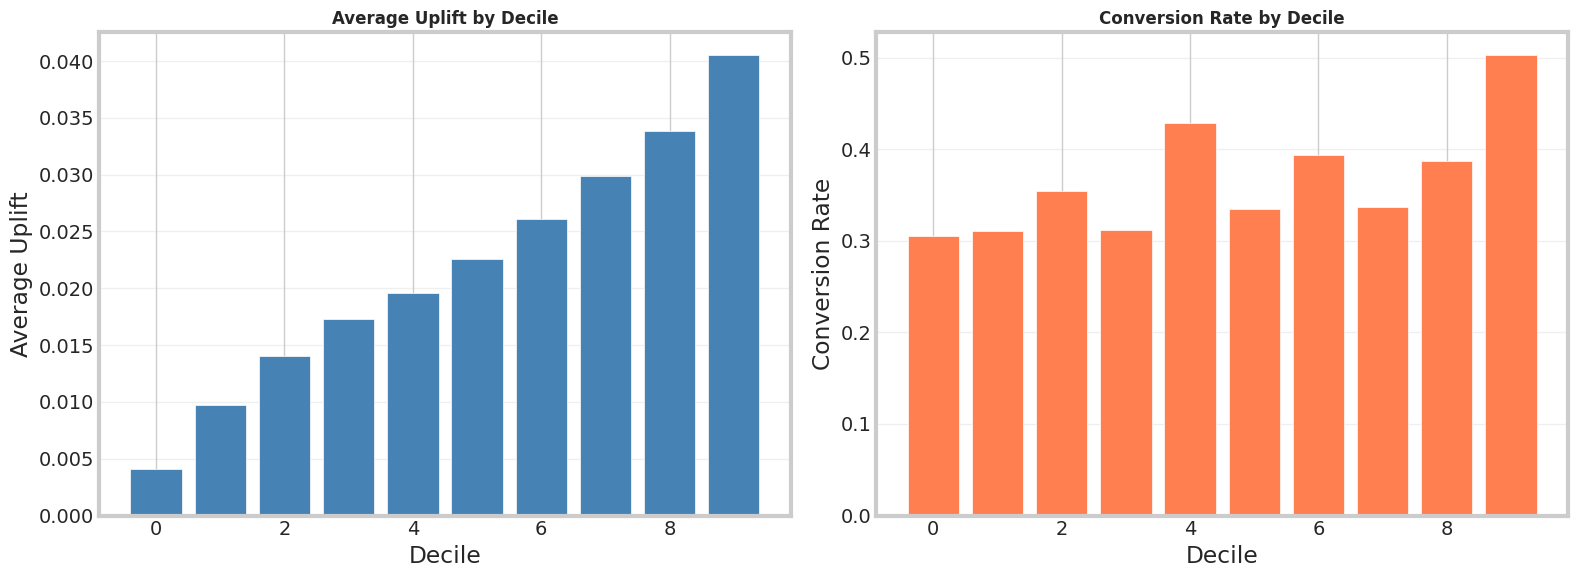

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(uplift_summary['uplift_decile'], uplift_summary['Avg_Uplift'], color='steelblue')
axes[0].set_title('Average Uplift by Decile', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Decile')
axes[0].set_ylabel('Average Uplift')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(uplift_summary['uplift_decile'], uplift_summary['Conversion_Rate'], color='coral')
axes[1].set_title('Conversion Rate by Decile', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Decile')
axes[1].set_ylabel('Conversion Rate')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
summary = f"""
DATASET OVERVIEW:
• Total observations: {len(df):,}
• Training: {len(df_train):,} | Validation: {len(df_valid):,}
• Original features: {len(feature_cols)} → After leakage removal: {X_train.shape[1]}
• Important features (CausalML): {len(important_cols)}

TARGET & TREATMENT:
• Target balance: {(y_train == 1).mean()*100:.1f}% moved
• Treatment balance: {(df_train['MESSAGE_A'] == 1).mean()*100:.1f}% treated

UPLIFT ANALYSIS:
• Average uplift: {df_valid['uplift_score'].mean():.4f}
• Positive uplift: {(df_valid['uplift_score'] > 0).mean()*100:.1f}%

BEST MODEL (Important Features):
• Model: {results_df_imp.iloc[0]['Model']}
• AUC: {results_df_imp.iloc[0]['AUC']:.4f}
• Accuracy: {results_df_imp.iloc[0]['Accuracy']:.4f}

RECOMMENDATIONS:
1. Target top 3 uplift deciles for campaign efficiency
2. Use {best_model_name} for predictions
3. Focus on top {len(important_cols)} CausalML features
4. Expected incremental impact: {df_valid['uplift_score'].mean():.4f} per voter
"""

print(summary)



DATASET OVERVIEW:
• Total observations: 10,000
• Training: 5,948 | Validation: 4,052
• Original features: 72 → After leakage removal: 72
• Important features (CausalML): 20

TARGET & TREATMENT:
• Target balance: 37.9% moved
• Treatment balance: 50.5% treated

UPLIFT ANALYSIS:
• Average uplift: 0.0217
• Positive uplift: 98.5%

BEST MODEL (Important Features):
• Model: GradientBoosting
• AUC: 0.9051
• Accuracy: 0.8384

RECOMMENDATIONS:
1. Target top 3 uplift deciles for campaign efficiency
2. Use GradientBoosting for predictions
3. Focus on top 20 CausalML features
4. Expected incremental impact: 0.0217 per voter



In [ ]:
results_df_imp.to_csv('model_results_important_features.csv', index=False)

results_df_full.to_csv('model_results_full_features.csv', index=False)

importances_df = importances.sort_values(ascending=False).reset_index()
importances_df.columns = ['Feature', 'Importance']
importances_df.to_csv('feature_importances_causalml.csv', index=False)

df_valid[['VOTER_ID', 'uplift_score', 'uplift_decile', 'MOVED_A']].to_csv('uplift_scores.csv', index=False)


uplift_summary.to_csv('uplift_summary_by_decile.csv', index=False)

comparison.to_csv('feature_set_comparison.csv', index=False)
